## Implementing Decision Trees for iris species:

## Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## 1. Data Preparation

In [20]:
df = pd.read_csv('iris.csv')
X = df.drop('species', axis=1).values
y = df['species'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=55)

## 2. Calculating Impurity Measure

In [12]:
def entropy(y):
    counter = Counter(y)
    total = len(y)
    ent = -sum((count / total) * math.log2(count / total) for count in counter.values())
    return ent

def gini_impurity(y):
    counter = Counter(y)
    total = len(y)
    gini = 1 - sum((count / total) ** 2 for count in counter.values())
    return gini

def information_gain(y, y_left, y_right, criterion='entropy'):
    if criterion == 'entropy':
        parent_entropy = entropy(y)
        left_entropy = entropy(y_left)
        right_entropy = entropy(y_right)
    elif criterion == 'gini':
        parent_entropy = gini_impurity(y)
        left_entropy = gini_impurity(y_left)
        right_entropy = gini_impurity(y_right)

    weight_left = len(y_left) / len(y)
    weight_right = len(y_right) / len(y)

    gain = parent_entropy - (weight_left * left_entropy + weight_right * right_entropy)
    return gain

## 3. Splitting Nodes

In [13]:
def split_data(X, y, feature_index, threshold):
    left_indices = np.where(X[:, feature_index] <= threshold)[0]
    right_indices = np.where(X[:, feature_index] > threshold)[0]
    return X[left_indices], X[right_indices], y[left_indices], y[right_indices]

## 4. Building Tree

In [14]:
class DecisionTree:
    def __init__(self, criterion='entropy', max_depth=None):
        self.criterion = criterion
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _best_split(self, X, y):
        best_gain = -1
        best_split = None
        n_features = X.shape[1]

        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                X_left, X_right, y_left, y_right = split_data(X, y, feature_index, threshold)

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                gain = information_gain(y, y_left, y_right, criterion=self.criterion)

                if gain > best_gain:
                    best_gain = gain
                    best_split = {
                        'feature_index': feature_index,
                        'threshold': threshold,
                        'left': (X_left, y_left),
                        'right': (X_right, y_right)
                    }

        return best_split

    def _build_tree(self, X, y, depth):
        if depth == self.max_depth or len(set(y)) == 1:
            return Counter(y).most_common(1)[0][0]

        best_split = self._best_split(X, y)
        if not best_split:
            return Counter(y).most_common(1)[0][0]

        left_subtree = self._build_tree(*best_split['left'], depth + 1)
        right_subtree = self._build_tree(*best_split['right'], depth + 1)

        return {
            'feature_index': best_split['feature_index'],
            'threshold': best_split['threshold'],
            'left': left_subtree,
            'right': right_subtree
        }

    def _predict(self, inputs, node):
      if not isinstance(node, dict):
          return node

      feature_index = node['feature_index']
      threshold = node['threshold']

      if inputs[feature_index] <= threshold:
          return self._predict(inputs, node['left'])
      else:
          return self._predict(inputs, node['right'])

    def predict(self, X):
        return [self._predict(inputs, self.tree) for inputs in X]

## 5. Visualization

In [15]:
def plot_tree(node, depth=0, parent=None, pos=None):
    if isinstance(node, dict):
        feature_index = node['feature_index']
        threshold = node['threshold']

        plt.text(pos[0], pos[1], f'X[{feature_index}] <= {threshold}', ha='center', bbox=dict(facecolor='white', edgecolor='black'))

        left_pos = (pos[0] - 1 / (depth + 1), pos[1] - 1)
        right_pos = (pos[0] + 1 / (depth + 1), pos[1] - 1)

        plt.plot([pos[0], left_pos[0]], [pos[1], left_pos[1]], 'k-')
        plt.plot([pos[0], right_pos[0]], [pos[1], right_pos[1]], 'k-')

        plot_tree(node['left'], depth + 1, node, left_pos)
        plot_tree(node['right'], depth + 1, node, right_pos)
    else:
        plt.text(pos[0], pos[1], f'Class: {node}', ha='center', bbox=dict(facecolor='lightgray', edgecolor='black'))

In [16]:
def visualize_decision_tree(tree):
    plt.figure(figsize=(12, 8))
    plot_tree(tree.tree, depth=0, pos=(0, 0))
    plt.title('Decision Tree Visualization')
    plt.axis('off')
    plt.show()

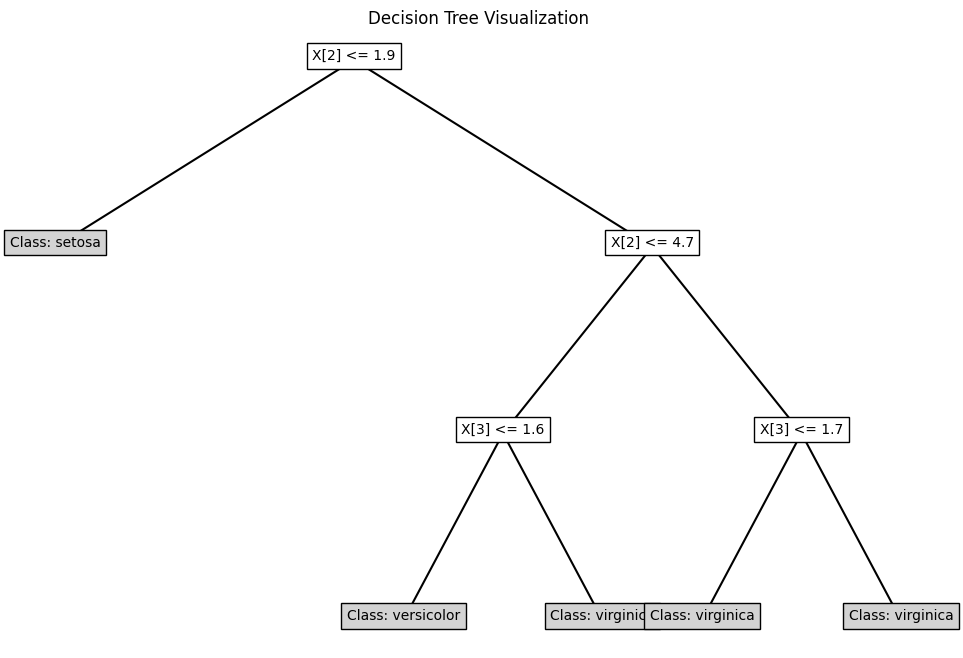

In [21]:
visualize_decision_tree(tree)

## 6. Evaluation

In [22]:
def evaluate_model(model, X_test, y_test):
      y_pred = model.predict(X_test)
      accuracy = accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred, average='weighted')
      recall = recall_score(y_test, y_pred, average='weighted')
      f1 = f1_score(y_test, y_pred, average='weighted')

      print(f'Accuracy: {accuracy}')
      print(f'Precision: {precision}')
      print(f'Recall: {recall}')
      print(f'F1-Score: {f1}')

tree = DecisionTree(criterion='gini', max_depth=3)
tree.fit(X_train, y_train)
evaluate_model(tree, X_test, y_test)

Accuracy: 0.94
Precision: 0.9485714285714286
Recall: 0.94
F1-Score: 0.9392042440318303
